In [92]:
import numpy as np,pandas as pd
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import confusion_matrix,accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.preprocessing import LabelEncoder 
import datetime as dt

In [93]:
test=pd.read_csv('patient_monthwise_revenue_test.csv')
train=pd.read_csv('patient_monthwise_revenue_train.csv')
test_p=pd.read_csv('physio_diagnosis_test.csv')
train_p=pd.read_csv('physio_diagnosis_train.csv')
train_cl=pd.read_csv('patient_train_classified.csv')
train_ph=pd.read_csv('physio_appts_train.csv')

#

/home/rajat/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/rajat/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [94]:
sub=pd.read_csv('Submission.csv')

### PREPROCESSING

In [95]:
train_cl.columns=['patient_id','Bucket','revenue']
train_cl.head()

,patient_id,Bucket,revenue
0,400061,Med,1200.0
1,25535,High,25150.0
2,409013,Med,4480.0
3,164585,Low,500.0
4,56960,Low,500.0


In [96]:
train.drop('revenue',axis=1,inplace=True)
train=pd.merge(train,train_cl,on='patient_id').drop(['Bucket'],axis=1)

In [97]:
train.drop(['Unnamed: 20','Unnamed: 21'],axis=1,inplace=True)
test.drop(['Unnamed: 18','Unnamed: 19'],axis=1,inplace=True)
train_p.drop(['Unnamed: 7','Unnamed: 8'],axis=1,inplace=True)
test_p.drop(['Unnamed: 6','Unnamed: 7'],axis=1,inplace=True)

In [98]:
train.service_name.fillna('None',inplace=True)
test.service_name.fillna('None',inplace=True)
train.gender.fillna('None',inplace=True)
test.gender.fillna('None',inplace=True)
train.diagnosis.fillna('None',inplace=True)
test.diagnosis.fillna('None',inplace=True)


In [99]:
test.shape,train.shape,train_p.shape,test_p.shape,train_cl.shape,train_ph.shape

((55329, 18), (83307, 20), (48804, 7), (32455, 6), (48804, 3), (501324, 10))

In [100]:
temp=train.groupby(['patient_id'])[['visits_count']].sum().reset_index()
temp.head()

,patient_id,visits_count
0,10020,1
1,10293,7
2,10381,27
3,10388,64
4,10611,15


In [101]:
train.drop('visits_count',axis=1,inplace=True)
train=pd.merge(train,temp,on='patient_id')

In [102]:
train.head()

,patient_id,visit_month_year,service_id,city,ref_type,ref_name,ref_source,service_name,FVD,FVM,FVS,approx_age,gender,LVD,brand,visits_required,diagnosis,avg_nps,revenue,visits_count
0,10020,04/15,2,Chennai,B2C,None,Direct Organic,P,21/04/2015,04/15,P,62,male,21/04/2015,Portea,1,Post Operative condition of Cardiac Valve repl...,\N,500.0,1
1,10293,04/17,2,Mumbai,B2C,Facebook,Digital + ATL,P,08/04/2017,04/17,P,42,female,25/04/2017,Portea,8,Rheumatoid arthritis,9,4900.0,7
2,10381,07/15,2,NCR,B2C,None,Direct Organic,P,31/07/2015,07/15,P,67,male,11/09/2015,Portea,10,frozen shoulder,8,12250.0,27
3,10381,08/15,2,NCR,B2C,None,Direct Organic,P,31/07/2015,07/15,P,67,male,11/09/2015,Portea,10,frozen shoulder,8,12250.0,27
4,10381,08/15,98,NCR,B2C,None,Direct Organic,P,31/07/2015,07/15,P,67,male,11/09/2015,Portea,10,frozen shoulder,8,12250.0,27


In [103]:
def date_feature(df):
    df.FVD=df.FVD.apply(lambda x:dt.datetime.strptime(x,'%d/%m/%Y'))
    df.LVD=df.LVD.apply(lambda x:dt.datetime.strptime(x,'%d/%m/%Y'))
    df['date_diff']=t.LVD.sub(t.FVD).astype(dt.timedelta).map(lambda x: np.nan if pd.isnull(x) else x.days)
    df['fvd_year']=df.FVD.dt.year
    df['fvd_month']=df.FVD.dt.month
    df['fvd_day']=df.FVD.dt.day
    df['lvd_year']=df.LVD.dt.year
    df['lvd_month']=df.LVD.dt.month
    df['lvd_day']=df.LVD.dt.day
    df.drop(['FVD','LVD'],axis=1,inplace=True)
    return df
    

In [104]:
train=date_feature(train)

In [105]:
test=date_feature(test)

In [106]:
train['is_train']=1
test['is_train']=0

In [107]:
tt=pd.concat([train,test],ignore_index=True)
print(tt.shape)
tt.head()

(138636, 26)


,FVM,FVS,approx_age,avg_nps,brand,city,date_diff,diagnosis,fvd_day,fvd_month,...,patient_id,ref_name,ref_source,ref_type,revenue,service_id,service_name,visit_month_year,visits_count,visits_required
0,04/15,P,62,\N,Portea,Chennai,0,Post Operative condition of Cardiac Valve repl...,21,4,...,10020,None,Direct Organic,B2C,500.0,2,P,04/15,1.0,1
1,04/17,P,42,9,Portea,Mumbai,17,Rheumatoid arthritis,8,4,...,10293,Facebook,Digital + ATL,B2C,4900.0,2,P,04/17,7.0,8
2,07/15,P,67,8,Portea,NCR,42,frozen shoulder,31,7,...,10381,None,Direct Organic,B2C,12250.0,2,P,07/15,27.0,10
3,07/15,P,67,8,Portea,NCR,42,frozen shoulder,31,7,...,10381,None,Direct Organic,B2C,12250.0,2,P,08/15,27.0,10
4,07/15,P,67,8,Portea,NCR,42,frozen shoulder,31,7,...,10381,None,Direct Organic,B2C,12250.0,98,P,08/15,27.0,10


In [ ]:
#tt['vmy_month']=tt.visit_month_year.apply(lambda x: x[0:2])
#tt['vmy_year']=tt.visit_month_year.apply(lambda x: x[3:5])

In [108]:
tt.drop(['FVM','service_id','service_name','visit_month_year'],axis=1,inplace=True)


In [109]:
tt['visit_diff']=tt.visits_required-tt.visits_count

In [110]:
tt.replace(to_replace="\\N",value='-1',inplace=True)

In [111]:
tt.approx_age=tt.approx_age.astype('int64')
#tt.vmy_year=tt.vmy_year.astype('int64')


In [112]:
for i in tt.columns :
    if tt[i].dtypes=='object':
        print(i)
        le=LabelEncoder()
        tt[i]=le.fit_transform(tt[i])
        #est[i]=le.transform(test[i])

FVS
avg_nps
brand
city
diagnosis
gender
ref_name
ref_source
ref_type


In [113]:
train=tt[tt.is_train==1]
test=tt[tt.is_train==0].drop(['revenue','visits_count'],axis=1)
del tt

### MODELS

In [ ]:
test.columns

In [ ]:
#train.drop_duplicates(keep='first',inplace=True)
#train.is_click.value_counts()

In [115]:
X=train.drop(['revenue','patient_id'],axis=1)
Y=train.revenue

In [ ]:
X.shape,Y.shape

In [116]:
x_train,x_test,y_train,y_test= train_test_split(X,Y,test_size=0.10,random_state=4)

In [117]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,mean_squared_error

In [118]:
def rmse(yt,yp):
    return mean_squared_error(yt,yp)**0.5

In [119]:
rf=RandomForestRegressor(n_estimators=1000, criterion='mse', max_depth=10, max_features='sqrt',
                            n_jobs=-1, random_state=0)
rf.fit(x_train,y_train)
pred_rf=rf.predict(x_test)
print(rmse(y_test,pred_rf))#,accuracy_score(y_test,pred_rf)
#confusion_matrix(y_test,pred_rf)

2760.99843462


In [120]:
featimp = pd.Series(rf.feature_importances_,index=x_train
                    .columns).sort_values(ascending=False)
print(featimp) # this is the property of Random Forest classifier that it provide us the importance 

visits_count       0.336737
visit_diff         0.281056
date_diff          0.132272
visits_required    0.047296
lvd_month          0.027077
ref_name           0.024341
approx_age         0.019501
diagnosis          0.017792
lvd_year           0.016337
ref_type           0.016089
ref_source         0.015497
lvd_day            0.013061
fvd_day            0.011556
fvd_month          0.009847
fvd_year           0.009789
avg_nps            0.009537
city               0.008283
gender             0.002148
brand              0.001785
is_train           0.000000
FVS                0.000000
dtype: float64


In [121]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test)

In [122]:
param = {
    'max_depth':10,# the maximum depth of each tree
    'eta': 0.1,# the training step for each iteration
    'silent': 1,  # logging mode - quiet
    'objective': 'reg:linear',  # error evaluation for multiclass training
    'eval_metric':'error',
    
}  # the number of classes that exist in this datset
num_round = 500
bst1 = xgb.train(param, dtrain, num_round)
pred_xg = bst1.predict(dtest)
#pred_xg = np.where(pred>=0.5,1,0)
print(rmse(y_test,pred_xg))
#confusion_matrix(y_test,pred_xg)

291.046422218


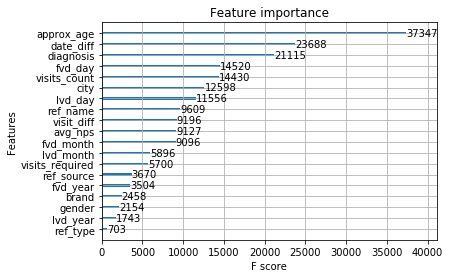

In [123]:
plot_importance(bst1)

In [ ]:
test

In [124]:
temp=pd.DataFrame()
temp['patient_id']=test.groupby(['patient_id']).count().reset_index()['patient_id']
temp['visits_count']=test.groupby(['patient_id']).count().reset_index()['FVS']
temp.head()

,patient_id,visits_count
0,122,12
1,129,2
2,10251,2
3,10496,14
4,10701,5


In [125]:
test=pd.merge(test,temp,on='patient_id')
test.head()

,FVS,approx_age,avg_nps,brand,city,date_diff,diagnosis,fvd_day,fvd_month,fvd_year,...,lvd_day,lvd_month,lvd_year,patient_id,ref_name,ref_source,ref_type,visits_required,visit_diff,visits_count
0,0,3,25,11,20,0,22134,14,11,2013,...,11,3,2015,122,251,6,1,2,NaN,12
1,0,3,25,11,20,17,22134,14,11,2013,...,11,3,2015,122,251,6,1,2,NaN,12
2,0,3,25,11,20,42,22134,14,11,2013,...,11,3,2015,122,251,6,1,2,NaN,12
3,0,3,25,11,20,42,22134,14,11,2013,...,11,3,2015,122,251,6,1,2,NaN,12
4,0,3,25,11,20,42,22134,14,11,2013,...,11,3,2015,122,251,6,1,2,NaN,12


In [126]:
test.columns

Index(['FVS', 'approx_age', 'avg_nps', 'brand', 'city', 'date_diff',
       'diagnosis', 'fvd_day', 'fvd_month', 'fvd_year', 'gender', 'is_train',
       'lvd_day', 'lvd_month', 'lvd_year', 'patient_id', 'ref_name',
       'ref_source', 'ref_type', 'visits_required', 'visit_diff',
       'visits_count'],
      dtype='object')

In [127]:
test.drop_duplicates(keep='last',inplace=True)
test.shape

(41994, 22)

In [ ]:
sub.columns={'patient_id','Bucket'}
sub=pd.merge(sub,test,on='patient_id')

In [ ]:
sub.head()

In [ ]:
ddtest=xgb.DMatrix(sub[x_train.columns])
#sub=pd.DataFrame()
#sub['id']=test.id
pred =rf.predict(sub[x_train.columns])#+bst2.predict(ddtest)+rf.predict_proba(test.drop('id',axis=1))[:,1])/3
#sub['is_click']=np.where(pred>=0.5,1,0)
#sub.is_click.value_counts()
#pred

In [ ]:
def buc(x):
    if x<=1000:
        return 'Low'
    elif x>1000 and x<=5000:
        return 'Med'
    elif x>5000 and x<=10000:
        return 'High-Med'
    elif x>10000:
        return 'High'

In [ ]:
sub=sub[['patient_id','Bucket']]
#sub['id']=test.id
sub['Bucket']=pred#lr.predict(test.drop('id',axis=1))
sub.head()

In [ ]:
sub.Bucket=sub.Bucket.apply(lambda x : buc(x))
sub.head()

In [ ]:
sub.columns={'PID','Bucket'}
sub.head()

In [ ]:
sub.to_csv('sub-xgbt.csv',index=False)